In [51]:
%matplotlib inline

import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display

pd.set_option('expand_frame_repr', False)

In [52]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
#mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue   [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green  [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red    [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown  [10,11]
             (227, 119, 194), (247, 182, 210), # pink   [12,13]
             (127, 127, 127), (199, 199, 199), # gray   [14,15]
             (188, 189, 34 ), (219, 219, 141), # yellow [16,17]
             (23 , 190, 207), (158, 218, 229)] # cyan   [18,19]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
def load_data(rdir):
    sessions = {}
    experiments = {}
    start = rdir.rfind(os.sep)+1
    for path, dirs, files in os.walk(rdir):
        folders = path[start:].split(os.sep)
        if len(path[start:].split(os.sep)) == 2:
            sid = os.path.basename(glob.glob('%s/*.json' % path)[0])[:-5]
            if sid not in sessions.keys():
                sessions[sid] = {}
            sessions[sid] = ra.Session(sid, 'radical.pilot', src=path)
            experiments[sid] = folders[0]
    return sessions, experiments

# Load experiments' dataset into ra.session objects
# stored in a DataFrame.
rdir = '/Users/mturilli/Projects/RADICAL/github/experiments/AIMES-Swift/viveks_workflow/analysis/sessions/data/'
sessions, experiments = load_data(rdir)
sessions = pd.DataFrame({'session': sessions,
                         'experiment': experiments})

In [4]:
for sid in sessions.index:
    sessions.ix[sid, 'TTC'] = sessions.ix[sid, 'session'].ttc

In [5]:
for sid in sessions.index:
    sessions.ix[sid, 'nunit'] = len(sessions.ix[sid, 'session'].filter(etype='unit', inplace=False).get())

In [ ]:
sessions

In [6]:
# Model of TOTAL pilot durations.
# ttpdm = {'TT_PILOT_PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
#          'TT_PILOT_PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
#          'TT_PILOT_LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
#          'TT_PILOT_LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
#          'TT_PILOT_LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
#                                                                  'CANCELED',
#                                                                  'FAILED']]}
ttpdm = {'TT_PILOT_LRMS_QUEUING'   : [rp.PMGR_ACTIVE_PENDING   ,  rp.PMGR_ACTIVE]}
    
# Add total pilot durations to sessions' DF.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for d in ttpdm.keys():
        sessions.ix[sid, d] = s.duration(ttpdm[d])

In [7]:
# Model of pilot durations.
pdm = {#'PMGR_SCHEDULING': [rp.NEW                   ,  rp.PMGR_LAUNCHING_PENDING],
       #'PMGR_QUEUING'   : [rp.PMGR_LAUNCHING_PENDING,  rp.PMGR_LAUNCHING],
       #'LRMS_SUBMITTING': [rp.PMGR_LAUNCHING        ,  rp.PMGR_ACTIVE_PENDING],
       'LRMS_QUEUING'   : [rp.PMGR_ACTIVE_PENDING   ,  rp.PMGR_ACTIVE]}#,
       #'LRMS_RUNNING'   : [rp.PMGR_ACTIVE           , [rp.DONE,
                                                      #rp.CANCELED,
                                                      #rp.FAILED]]}

# DataFrame structure for pilot durations. 
# pds = { 'pid': [],
#         'sid': [],
#         'experiment'     : [],
#         'PMGR_SCHEDULING': [],
#         'PMGR_QUEUING'   : [],
#         'LRMS_SUBMITTING': [],
#         'LRMS_QUEUING'   : [],
#         'LRMS_RUNNING'   : []}

pds = {'pid': [],
       'sid': [],
       'experiment': [],
       'LRMS_QUEUING': []}


# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for p in s.list('uid'):
        sf = s.filter(uid=p, inplace=False)        
        pds['pid'].append(p)
        pds['sid'].append(sid)
        pds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in pdm.keys():
            if (not sf.timestamps(state=pdm[d][0]) or 
                not sf.timestamps(state=pdm[d][1])):
                pds[d].append(None)
                continue
            pds[d].append(sf.duration(pdm[d]))

# Populate the DataFrame.
pilots = pd.DataFrame(pds)

In [8]:
# Model of unit durations.
# udm = {'TT_UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       #'TT_UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       #'TT_IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       #'TT_IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       #'TT_IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       #'TT_IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       #'TT_IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       #'TT_UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       #'TT_UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       #'TT_UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       #'TT_UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING']} 
       #'TT_OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       #'TT_OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       #'TT_OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       #'TT_OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

udm = {'TT_UNIT_AGENT_EXECUTING'   : [rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING]}

# Calculate total unit durations for each session.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
#     for unit in s.get(etype='unit'):
#         print
#         print s._sid
#         print unit.uid
#         for state in unit.states:
#             print "%-20s : %7.2f" % (state, unit.states[state]['time'])    

    for d in udm.keys():
        sessions.ix[sid, d] = s.duration(udm[d])

In [ ]:
sessions

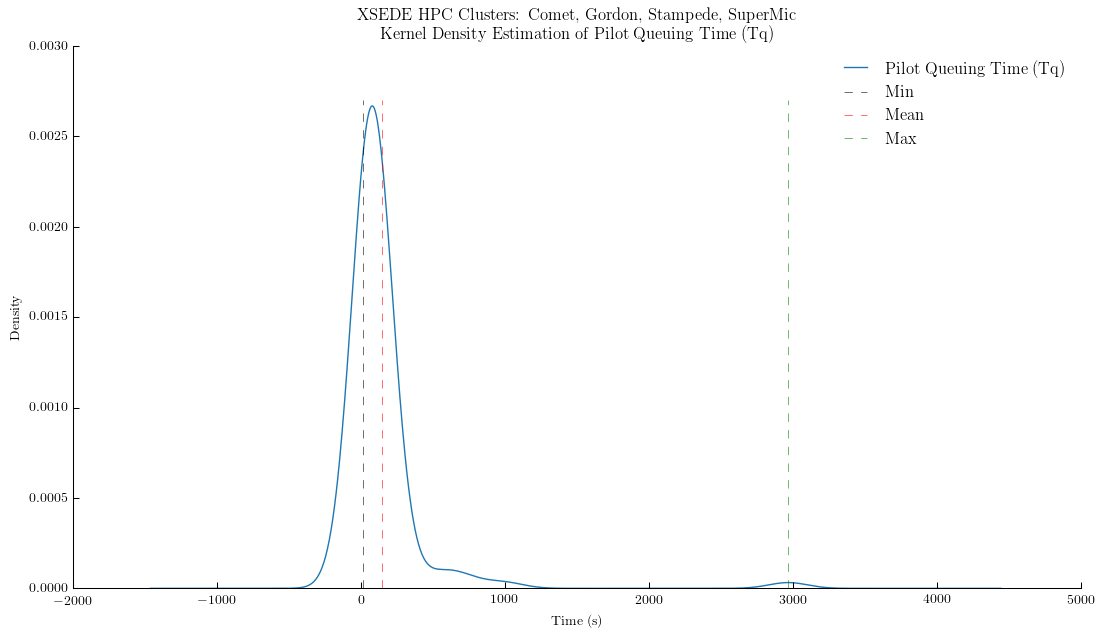

In [9]:
fig, ax = fig_setup()
title='XSEDE HPC Clusters: Comet, Gordon, Stampede, SuperMic\nKernel Density Estimation of Pilot Queuing Time (Tq)'

tq_all  = pilots['LRMS_QUEUING'].dropna().reset_index(drop=True)

ptqs = pd.DataFrame({'all': tq_all}) 

ptqs.plot.density(ax=ax, color=tableau20[0], title=title)
plt.axvline(pilots['LRMS_QUEUING'].min(),  ymax=0.9, color='black', linestyle='dashed', linewidth=0.4)
plt.axvline(pilots['LRMS_QUEUING'].mean(), ymax=0.9, color='red',   linestyle='dashed', linewidth=0.4)
plt.axvline(pilots['LRMS_QUEUING'].max(),  ymax=0.9, color='green', linestyle='dashed', linewidth=0.4)

ax.set_xlabel('Time (s)')
ax.legend(labels=['Pilot Queuing Time (Tq)', 'Min', 'Mean', 'Max'])

plt.savefig('xsede_tq_all_density.pdf', dpi=600, bbox_inches='tight')
#display(pilots)

In [10]:
# Model of unit durations.
# udm = {'UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
#        'UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
#        'IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
#        'IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
#        'IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
#        'IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
#        'IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
#        'UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
#        'UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
#        'UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
#        'UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'],
#        'OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
#        'OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
#        'OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
#        'OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

udm = {'UNIT_AGENT_EXECUTING'   : [rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING]}
        
# DataFrame structure for pilot durations. 
# uds = { 'pid': [],
#         'sid': [],
#         'experiment' : [],
#         'UNIT_UMGR_SCHEDULING'   : [],
#         'UNIT_UMGR_BINDING'      : [],
#         'IF_UMGR_SCHEDULING'     : [], 
#         'IF_UMGR_QUEING'         : [],
#         'IF_AGENT_SCHEDULING'    : [],
#         'IF_AGENT_QUEUING'       : [], 
#         'IF_AGENT_TRANSFERRING'  : [],
#         'UNIT_AGENT_QUEUING'     : [],
#         'UNIT_AGENT_SCHEDULING'  : [], 
#         'UNIT_AGENT_QUEUING_EXEC': [], 
#         'UNIT_AGENT_EXECUTING'   : [], 
#         'OF_AGENT_QUEUING'       : [], 
#         'OF_UMGR_SCHEDULING'     : [],
#         'OF_UMGR_QUEUING'        : [],
#         'OF_UMGR_TRANSFERRING'   : []}

uds = { 'uid': [],
        'sid': [],
        'experiment': [],
        'UNIT_AGENT_EXECUTING': []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions[['session', 'experiment']].index:
    print sid
#     if sessions.ix[sid, 'experiment'] in ['exp1','exp2']:
#         continue
#     print '%s - %s' % (sessions.ix[sid, 'experiment'], sid)
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for u in s.list('uid'):
#         print "\t%s" % u
        sf = s.filter(uid=u, inplace=False)
        uds['uid'].append(u)
        uds['sid'].append(sid)
        uds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in udm.keys():
            # print '\t\t%s' % udm[d]
            # print '\t\t[%s, %s]' % (sf.timestamps(state=udm[d][0]), sf.timestamps(state=udm[d][1])) 
            if (not sf.timestamps(state=udm[d][0]) or 
                not sf.timestamps(state=udm[d][1])):
                pds[d].append(None)
#                 print '\t\t%s: %s' % (d, 'None')
                continue
#             print sf.timestamps(state=udm[d][0])
#             print sf.timestamps(state=udm[d][1])
#             print '\t\t%s: %s' % (d, sf.duration(udm[d]))
            uds[d].append(sf.duration(udm[d]))

# Populate the DataFrame. We have empty lists 
units = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in uds.iteritems()]))

rp.session.radical.merzky.017082.0014
rp.session.radical.merzky.017083.0001
rp.session.radical.merzky.017083.0005
rp.session.radical.merzky.017083.0007
rp.session.radical.merzky.017083.0009
rp.session.radical.merzky.017083.0011
rp.session.radical.merzky.017083.0013
rp.session.radical.merzky.017083.0015
rp.session.radical.merzky.017083.0017
rp.session.radical.merzky.017083.0025
rp.session.radical.merzky.017083.0027
rp.session.radical.merzky.017083.0029


KeyboardInterrupt: 

In [16]:
# get all session IDs and profile paths
dirs = glob.glob('/Users/mturilli/Projects/RADICAL/github/experiments/AIMES-Swift/viveks_workflow/analysis/sessions/data/exp1/rp.session.*/')
sids = dict()
for d in dirs:
    while d.endswith('/'):
        d = d[:-1]
    sids[os.path.basename(d)] = d

# tx distribution is what we are interested in
tx        = list()
tx_states = [rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING]

# fill tx
last_states = dict()
for sid in sids:

    session = ra.Session(sid, 'radical.pilot', src=sids[sid])
    units   = session.filter(etype='unit', inplace=True)
    n       = len(units.get())

    for unit in units.get():

        # we only want units from stage 2
        if 'stage_2' not in unit.description['executable']:
            continue

        # get tx, and add it to the set of data points to plot.
        # ignore mismatching units.
        # also find out what the last state of the unit was (sorted by time)
        try:
            t = unit.duration(tx_states)
            if t:
                tx.append({'t' : t})
            ls = sorted(unit.states.keys(), key=lambda x: (unit.states[x]['time']))[-1]
        except:
            pass

        
        # update counter for the last states
        if ls not in last_states:
            last_states[ls] = 0
        last_states[ls] += 1

df  = pd.DataFrame(tx)

,t
0,379.6412
1,422.8411
2,400.1186
3,402.9694
4,412.1639
5,434.5441
6,436.4565
7,386.8066
8,315.2917
9,409.6533


In [43]:
units = pd.read_csv('/Users/mturilli/Projects/RADICAL/github/radical.analytics/use_cases/rp_on_osg/units_tx.csv')
# display(df['t'].tolist())
# display(units['UNIT_AGENT_EXECUTING'].tolist())
tx_xsede_osg = pd.DataFrame({'XSEDE': df['t'], 'OSG': units['UNIT_AGENT_EXECUTING']})
display(tx_xsede_osg)

,OSG,XSEDE
0,210.2204,379.6412
1,239.5106,422.8411
2,249.2585,400.1186
3,294.9099,402.9694
4,214.2163,412.1639
5,197.2057,434.5441
6,205.2098,436.4565
7,342.1608,386.8066
8,193.1973,315.2917
9,283.2868,409.6533


               OSG        XSEDE
count  6472.000000  9728.000000
mean    372.842403   318.983749
std     185.018101   105.522465
min     133.432300     0.962600
25%     240.953975   252.821650
50%     339.363100   255.261200
75%     457.453525   408.415675
max    2216.327500   950.575400


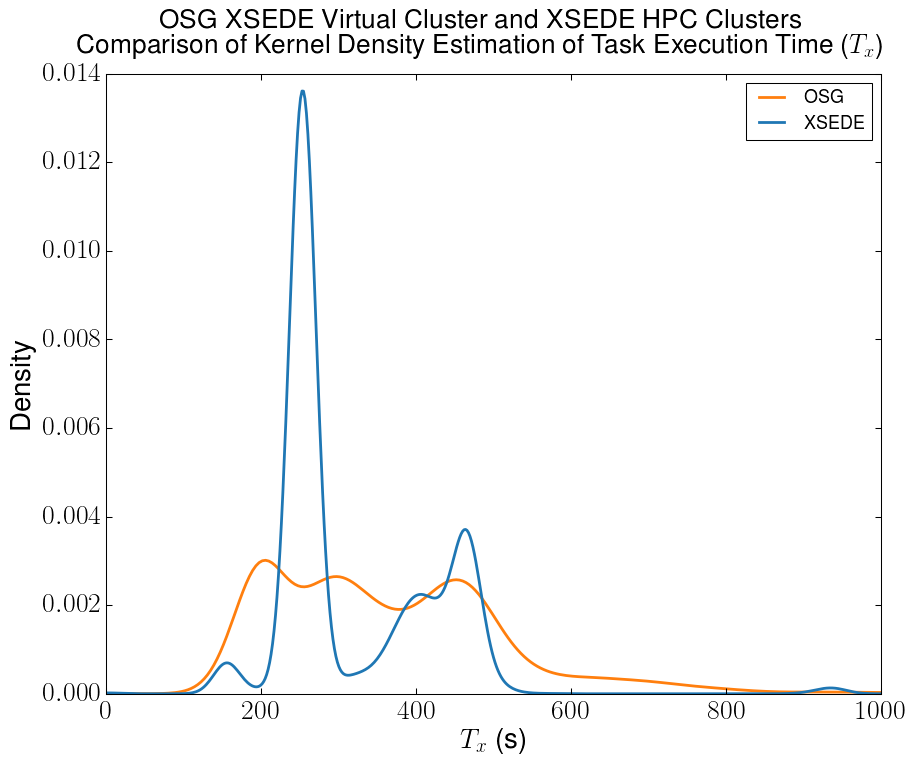

In [83]:
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif']  = ['Helvetica']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['patch.linewidth'] = 0.75

SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=13)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title



fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)  
mtitle ='OSG XSEDE Virtual Cluster and XSEDE HPC Clusters'
stitle ='Comparison of Kernel Density Estimation of Task Execution Time ($T_x$)'
title  = '%s\n%s' % (mtitle, stitle) 
fig.suptitle(title, fontsize=19)

# tx_all  = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)

# utxs = pd.DataFrame({'all': tx_all}) 

print tx_xsede_osg.describe()

tx_xsede_osg.plot.density(ax=ax, color=[tableau20[2],tableau20[0]], linewidth=2)#, title=title)
# plt.axvline(df['t'].min(),  ymax=0.9, color='black', linestyle='dashed', linewidth=0.4)
# plt.axvline(df['t'].mean(), ymax=0.9, color='red',   linestyle='dashed', linewidth=0.4)
# plt.axvline(df['t'].max(),  ymax=0.9, color='green', linestyle='dashed', linewidth=0.4)

ax.set_xlim((0, 1000))
ax.set_xlabel('$T_x$ (s)')
ax.legend()


plt.savefig('xsede_osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')
tx_xsede_osg.to_csv('osg_xsede_tx.csv')